In [1]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import os
import io
import cv2 

from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


## Step1. 검증용 데이터셋 준비


In [3]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/book/'
os.listdir(fold_path)

['.ipynb_checkpoints',
 '책5.png',
 '책9.png',
 '책10.png',
 '책1.png',
 '책8.png',
 '책2.png',
 '책3.png',
 '책4.png',
 '책6.png',
 '책7.png']

In [4]:
images_path = glob(fold_path+'*.png')
images_path

['/aiffel/aiffel/ocr_python/book/책5.png',
 '/aiffel/aiffel/ocr_python/book/책9.png',
 '/aiffel/aiffel/ocr_python/book/책10.png',
 '/aiffel/aiffel/ocr_python/book/책1.png',
 '/aiffel/aiffel/ocr_python/book/책8.png',
 '/aiffel/aiffel/ocr_python/book/책2.png',
 '/aiffel/aiffel/ocr_python/book/책3.png',
 '/aiffel/aiffel/ocr_python/book/책4.png',
 '/aiffel/aiffel/ocr_python/book/책6.png',
 '/aiffel/aiffel/ocr_python/book/책7.png']

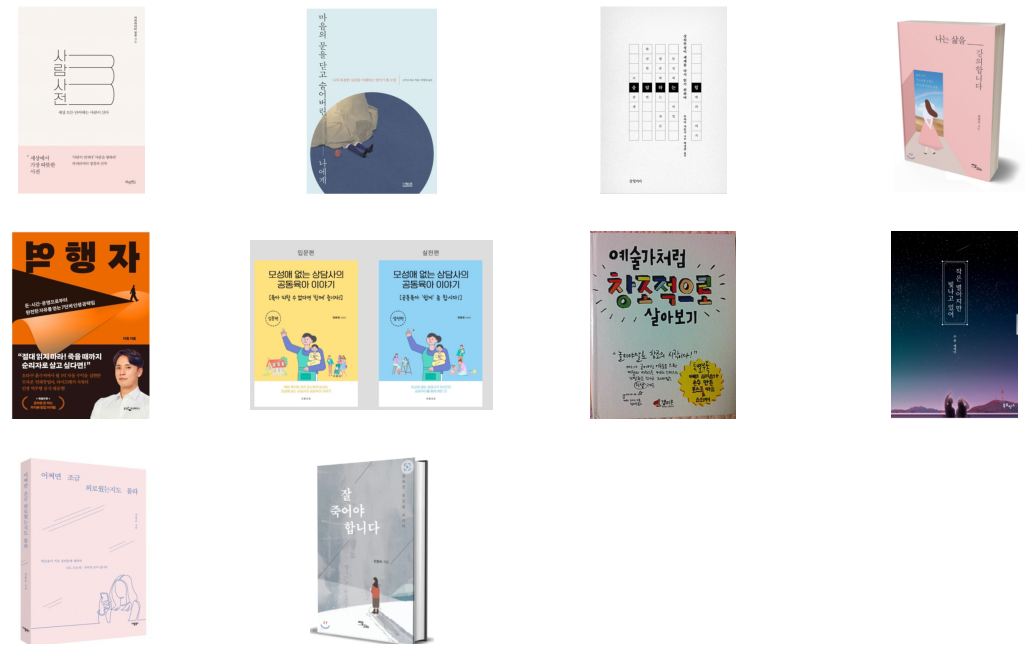

In [5]:
plt.figure(figsize=(20, 20))

for idx, image in enumerate(images_path):
    plt.subplot(5, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

책 이미지를 10개 정도 뽑아왔다.

책에는 글쓴이 책 제목 출판사 등의 정보가 있을 수 있다. 글씨체도 다양하고 기울어져 있기도 한 이미지들을 얼마나 잘 인식하는지 알아보겠다.


## Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)


### Google OCR API


In [6]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [7]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [8]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

ocr_img = []
ocr_dict = {}
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/book/책2'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

total 4596
-rw-r--r-- 1 root root 3771851 Jun 12 16:04 '12. 문자를 읽을 수 있는 딥러닝.ipynb'
-rw-r--r-- 1 root root    3101 Jun 13 16:12 '13. 인간보다 퀴즈를 잘푸는 인공지능.ipynb'
drwxr-xr-x 3 root root    4096 Jun 13 15:45 'exploration 모음'
drwxr-xr-x 3 root root    4096 Jun 13 15:45 'exploration 연습 모음'
-rw-r--r-- 1 root root  916513 Jun 14 02:45 'exploration 12.ipynb'
-rw-r--r-- 1 root root      48 Apr 15 01:52  README.md


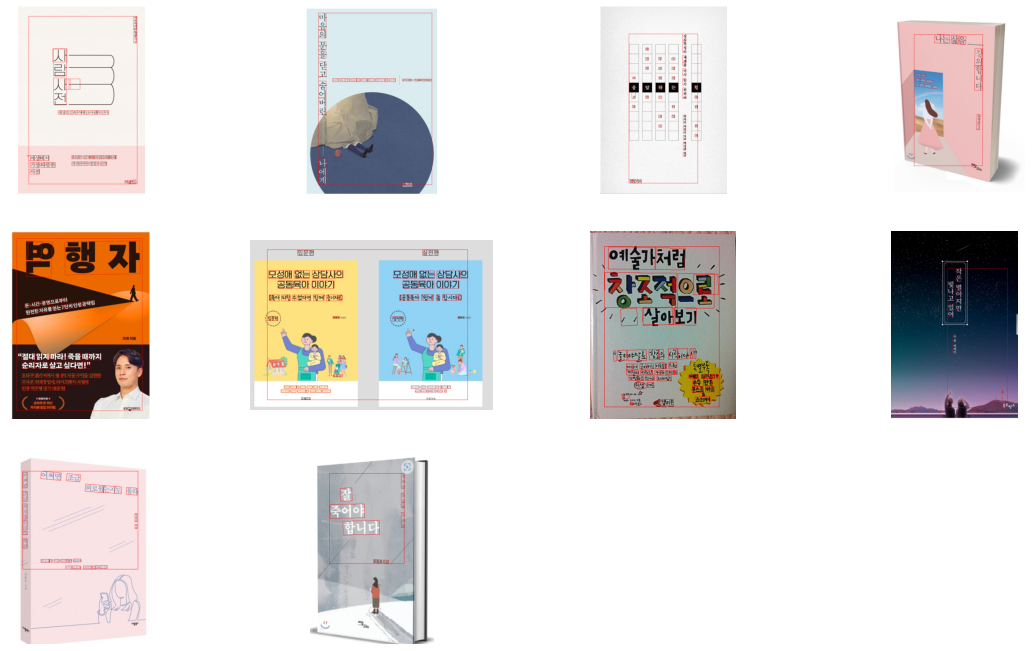

In [9]:
plt.figure(figsize=(20, 20))

for idx, img in enumerate(ocr_img):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

가장 마지막 책 잘 죽어야 합니다를 예시로 보자.

In [10]:
detect_text(path)

('책7',
 ['잘죽어야합니다최형숙 지음행복한 죽음을 위하여',
  '잘',
  '죽어야',
  '합니다',
  '최형숙',
  '지음',
  '행복한',
  '죽음',
  '을',
  '위하여'],
 [vertices {
    x: 63
    y: 56
  }
  vertices {
    x: 305
    y: 56
  }
  vertices {
    x: 305
    y: 349
  }
  vertices {
    x: 63
    y: 349
  },
  vertices {
    x: 97
    y: 104
  }
  vertices {
    x: 135
    y: 103
  }
  vertices {
    x: 136
    y: 145
  }
  vertices {
    x: 98
    y: 146
  },
  vertices {
    x: 64
    y: 157
  }
  vertices {
    x: 176
    y: 155
  }
  vertices {
    x: 177
    y: 200
  }
  vertices {
    x: 65
    y: 202
  },
  vertices {
    x: 106
    y: 211
  }
  vertices {
    x: 224
    y: 209
  }
  vertices {
    x: 225
    y: 254
  }
  vertices {
    x: 107
    y: 256
  },
  vertices {
    x: 206
    y: 335
  }
  vertices {
    x: 233
    y: 337
  }
  vertices {
    x: 232
    y: 347
  }
  vertices {
    x: 205
    y: 346
  },
  vertices {
    x: 238
    y: 337
  }
  vertices {
    x: 255
    y: 338
  }
  vertices {
    x: 254
    y: 3

 ['잘죽어야합니다', '최형숙 지음''행복한 죽음을 위하여',
  '잘',
  '죽어야',
  '합니다',
  '최형숙',
  '지음',
  '행복한',
  '죽음',
  '을',
  '위하여'],

등을 검출해내는것을 확인할 수 있다.

### 검출 결과

비교적  작은 글자도 잘 잡아낸다. 기울어져 있어도 글자를 잘 잡아내고 다만 예술가처럼 창조적으로 살아보기 책을 보면 일부 그림을 글자로 인식하는 경우도 있었다. 대부분 지은이나 제목은 잘 잡아내는 것 같다. 역시 구글이다.

사용결과 꽤나 만족할 만하게 검출해 낸것 같다.

### keras-ocr

In [18]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [12]:
images = [ keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

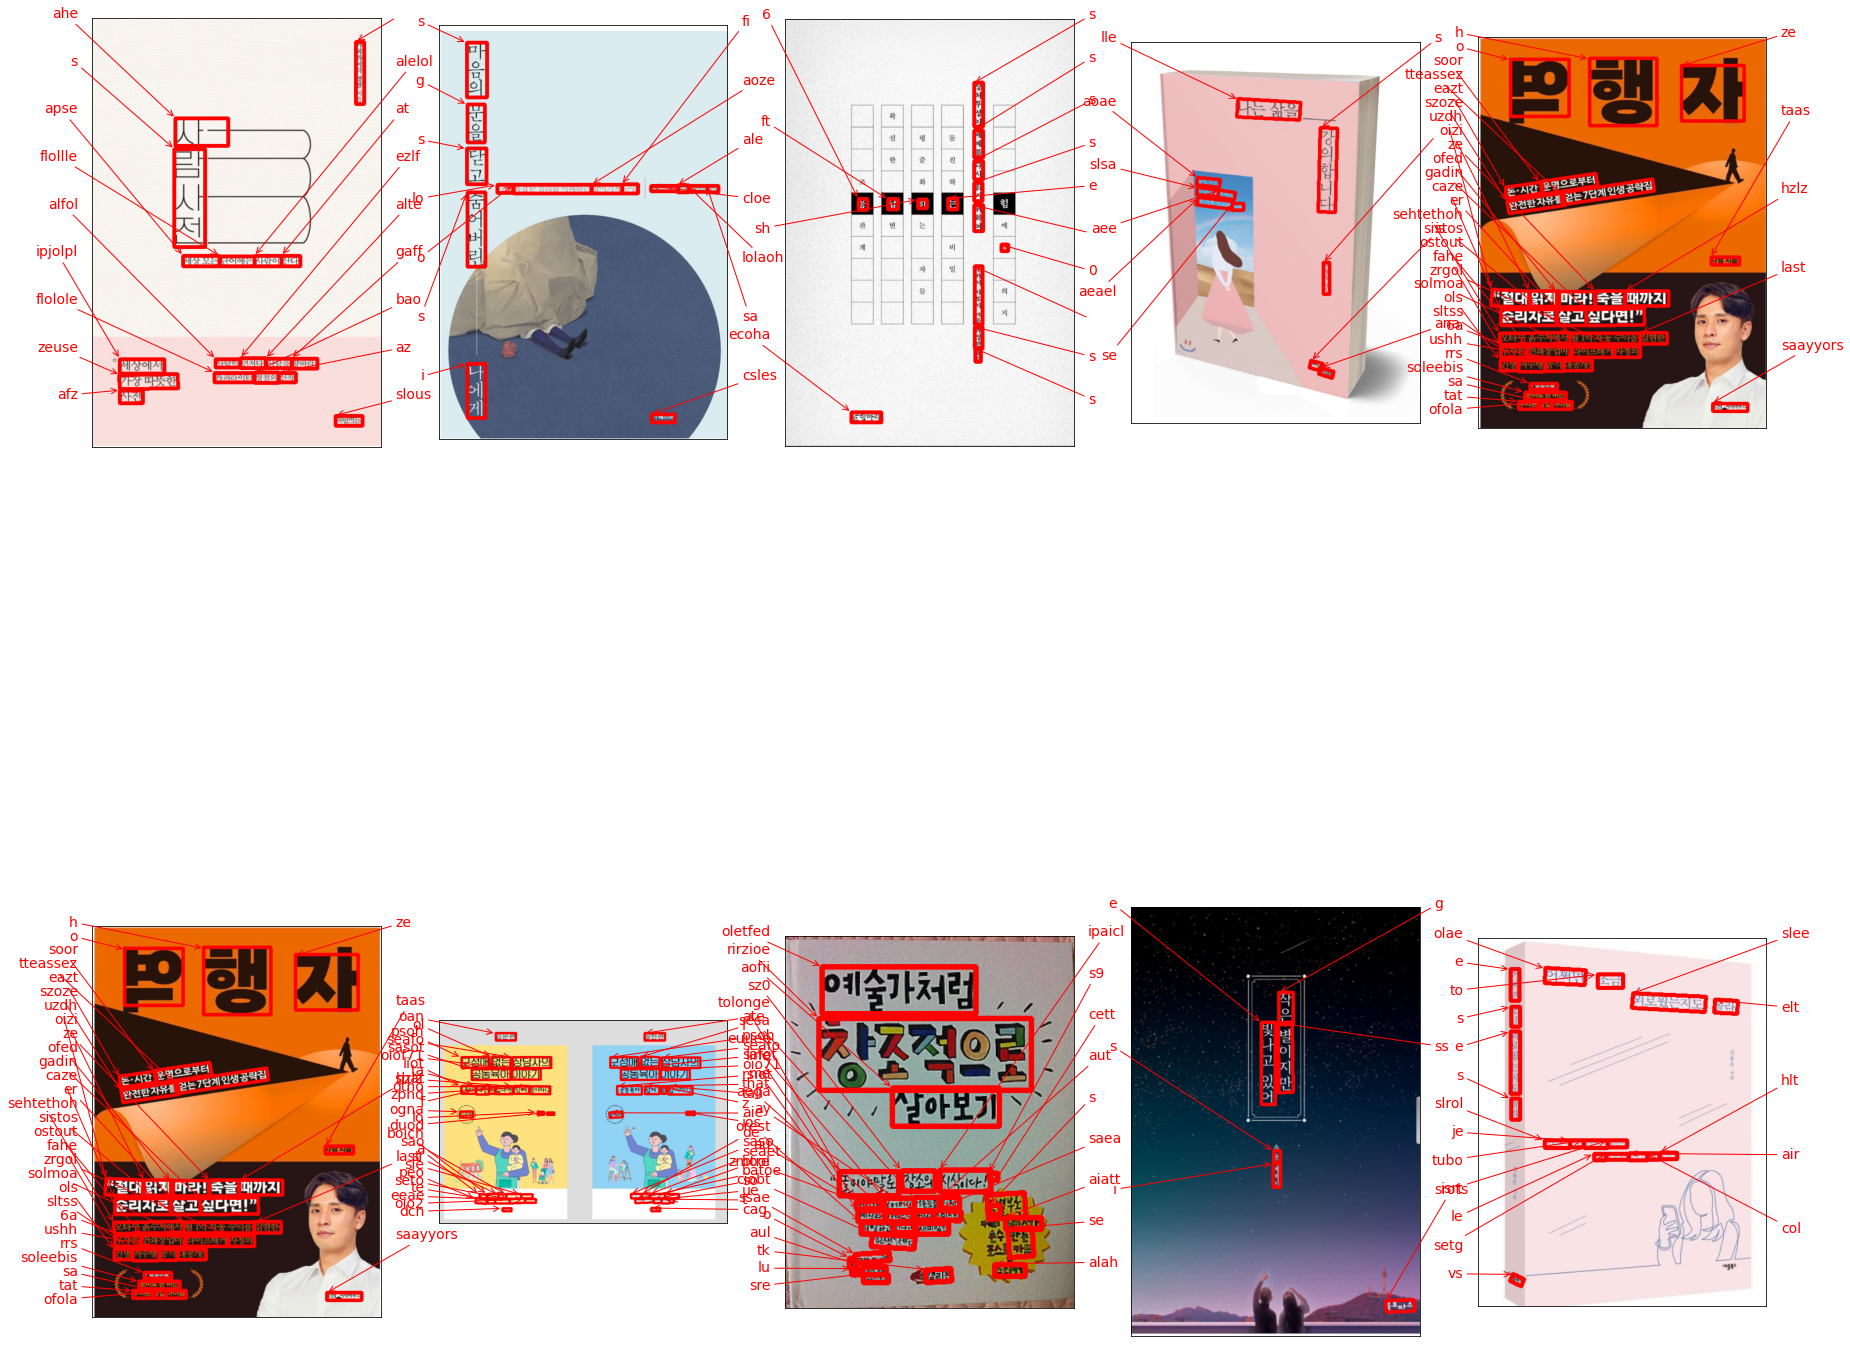

In [29]:
fig, axs = plt.subplots(2, 5, figsize=(30, 30))

for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[4*a+b], 
                                    predictions=predictions[4*a+b][0], ax=axs[a,b])

### 검출 결과

이런 아쉽게도 keras-ocr는 한국어를 지원하지 않는 것 같다...
그래도 구글 ocr api가 더 촘촘하게 잡아내고 '작은 별이지만 빛나고 있어' 를 보면 구글도 못잡아낸 출판사 '북로망스'도 잡아낸 걸 보아 만약 한국어가 지원됬다면 구글보다 더 좋은 결과를 냈을 것이라고 생각한다. 

## Tesseract

In [24]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/'
output_path = work_dir + '/book/' 

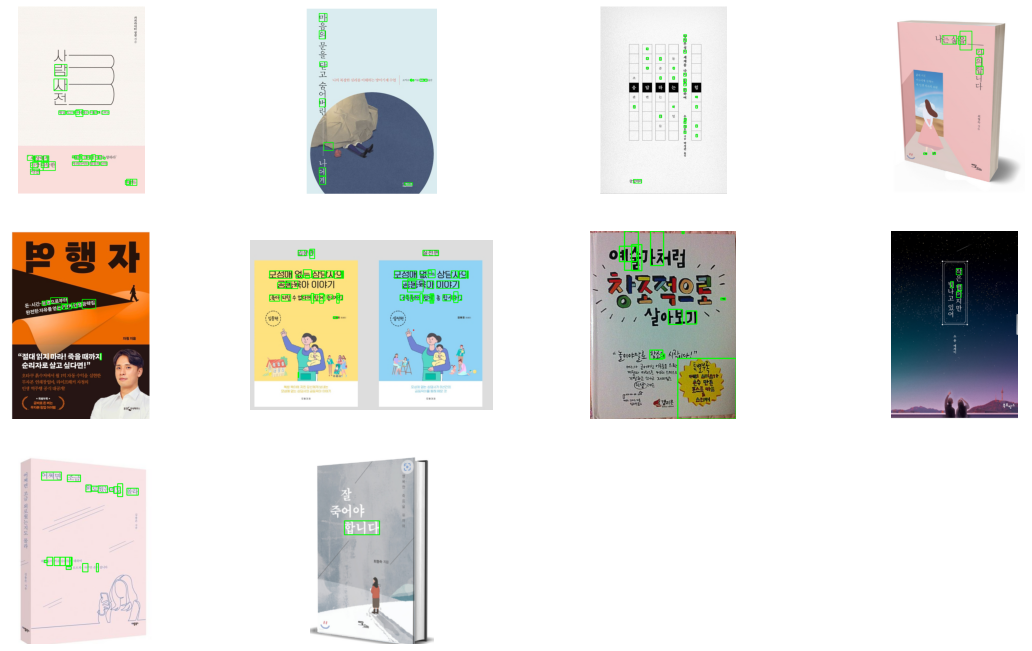

In [25]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(20, 20))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

### 검출결과 

테서렉트 한글팩을 써서 실행햇지만 조금 실망스러운 결과가 나왔다. 한글을 찾아내긴 하지만 그렇게 잘 찾아내는 것 같아 보이지 않았고 
평가 기준으로 삼은 책 제목이나, 지은이, 출판사를 잘 검출하지 못하고 있다. 

## Step3. 테스트 결과 정리 및 분석

Tesseract,keras-ocr, google ocr api 를 모두 써봤다.  결론을 내자면 테서렉트는 제일 특징을 잡아내지 못했고 Keras-ocr은 꼼꼼하게 잡아내지만 필요한 단어를 의미단의로 나누는 것은 잘 하지 못하는 것 같다. 그에 비해 구글 ocr api는 비교적 단어를 끊지 않고 잡아내는 것 같다.
만약 책 제목에 특정 단어가 들어가는 책을 찾을 때는 구글 api가 좋을 것 같고 특정 한 글자가 들어가는 책을 찾을 때는 keras - ocr을 이용하는게 좋을 것 같다. 개인적으로 keras -ocr이 한국어 지원이 안된 것이 아쉽다.